In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from skimage import filters
from IPython.display import display
from numba import njit

## "Lib"

In [2]:
@njit   # necessario para rodar com outras funcoes
def transform_255(img: np.ndarray) -> np.ndarray:
    fm = img - np.min(img)
    fs = 255 * (fm / np.amax(fm))
    return fs

In [3]:
def plot_histogram(im: np.ndarray, title=None) -> None:
    hist = np.zeros(256)
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            value = im[y][x]
            hist[value] += 1
    plt.figure(figsize=(18, 6))
    plt.bar(np.arange(256), hist)
    if title:
        plt.title(title, fontsize=20)
    plt.show()

In [4]:
@njit
def binarizar(img: np.ndarray, thresh_max: int, thresh_min=None, invert=False) -> np.ndarray:
    im_bin = np.empty(img.shape)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y][x] > thresh_max:
                im_bin[y][x] = 0
            else:
                if thresh_min:
                    if img[y][x] < thresh_min:
                        im_bin[y][x] = 0
                    else:
                        im_bin[y][x] = 1
                else:
                    im_bin[y][x] = 1
    if invert:
        im_bin = 1 - im_bin
    return im_bin

In [5]:
def median(img: np.ndarray, kernel_size: tuple[int,int]) -> np.ndarray:
    im_restored = np.empty(img.shape)
    h, w = img.shape[:2]
    wy = math.floor(kernel_size[0]/2)
    wx = math.floor(kernel_size[1]/2)
    for y in range(h):
        for x in range(w):
            tmp = []
            for i in range(-wy, wy + 1):
                vy = y + i
                for j in range(-wx, wx + 1):
                    vx = x + j
                    tmp.append(img[vy][vx] if 0 <= vy < h and 0 <= vx < w else img[y][x]) 
            im_restored[y][x] = np.median(tmp)
    im_restored = transform_255(im_restored)
    return im_restored.astype(np.uint8)

In [6]:
@njit
def arith_mean(img: np.ndarray, kernel_size: tuple[int, int]) -> np.ndarray:
    im_restored = np.empty(img.shape)
    area = kernel_size[0] * kernel_size[1]
    h, w = img.shape[:2]
    wy =  math.floor(kernel_size[0] / 2)
    wx = math.floor(kernel_size[1] / 2)
    for y in range(h):
        for x in range(w):
            tmp = 0
            for i in range(-wy, wy + 1):
                vy = y + i
                for j in range(-wx, wx + 1):
                    vx = x + j
                    tmp += img[vy][vx] if 0 <= vy < h and 0 <= vx < w else 0
            im_restored[y][x] = (1/area) * tmp
    im_restored = transform_255(im_restored)
    return im_restored.astype(np.uint8)

In [7]:
@njit
def agucar_laplace(img: np.ndarray, kernel_size: tuple[int, int]) -> np.ndarray:
    h, w = img.shape[:2]
    img_new = np.empty(img.shape)
    wy = math.floor(kernel_size[0] / 2)
    wx = math.floor(kernel_size[1] / 2)
    k = kernel_size[0] * kernel_size[1] - 1
    for y in range(h):
        for x in range(w):
            pixel = (-k) * img[y][x]
            for i in range(-wy, wy + 1):
                for j in range(-wx, wx + 1):
                    if i == 0 and j == 0:
                        continue
                    # zero padding
                    vy = y + i
                    vx = x + j
                    pixel += img[vy][vx] if 0 <= vy < h and 0 <= vx < w else 0
            img_new[y][x] = img[y][x] - pixel
    img_new = transform_255(img_new)
    # return img_new.astype(np.uint8)
    return transform_255(img_new + img).astype(np.uint8)

In [8]:
# @njit
def eq_histogram(img: np.ndarray) -> np.ndarray:
    hist = np.zeros(256)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            value = img[y][x]
            hist[value] += 1
    
    area = img.shape[0] * img.shape[1]
    eq_hist = np.zeros(256)
    tmp = 0
    for i in range(256):
        tmp += 255 * (hist[i] / area)
        eq_hist[i] = math.floor(tmp)
    
    im_eq = np.empty(img.shape)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            im_eq[y][x] = eq_hist[img[y][x]]
    return im_eq.astype(np.uint8)

In [9]:
@njit
def max_filter(img: np.ndarray, kernel_size: tuple[int, int]) -> np.ndarray:
    im_restored = np.empty(img.shape)
    h, w = img.shape[:2]
    wy = math.floor(kernel_size[0]/2)
    wx = math.floor(kernel_size[1]/2)
    for y in range(h):
        for x in range(w):
            tmp = 0
            for i in range(-wy, wy + 1):
                vy = y + i
                for j in range(-wx, wx + 1):
                    vx = x + j
                    if 0 <= vy < h and 0 <= vx < w:
                        if img[vy][vx] > tmp:
                            tmp = img[vy][vx]
            im_restored[y][x] = tmp
    return im_restored.astype(np.uint8)

In [10]:
@njit
def min_filter(img: np.ndarray, kernel_size: tuple[int, int]) -> np.ndarray:
    im_restored = np.empty(img.shape)
    h, w = img.shape[:2]
    wy = math.floor(kernel_size[0]/2)
    wx = math.floor(kernel_size[1]/2)
    for y in range(h):
        for x in range(w):
            tmp = 0
            for i in range(-wy, wy + 1):
                vy = y + i
                for j in range(-wx, wx + 1):
                    vx = x + j
                    if 0 <= vy < h and 0 <= vx < w:
                        if img[vy][vx] < tmp:
                            tmp = img[vy][vx]
            im_restored[y][x] = tmp
    return im_restored.astype(np.uint8)

In [39]:
def gama(img: np.ndarray, c: float=1, g: float=0.5):
    im_gama = c * np.power(img, g)
    im_gama = transform_255(im_gama)
    return im_gama.astype(np.uint8)

In [34]:
def pseudo_lp(img: np.ndarray, f: int) -> np.ndarray:
    im_tmp = np.where(img < f, img, 0)
    max_tmp = np.amax(im_tmp)
    im_lp = np.where(img < f, img, max_tmp)
    return im_lp.astype(np.uint8)

## Imagem 1

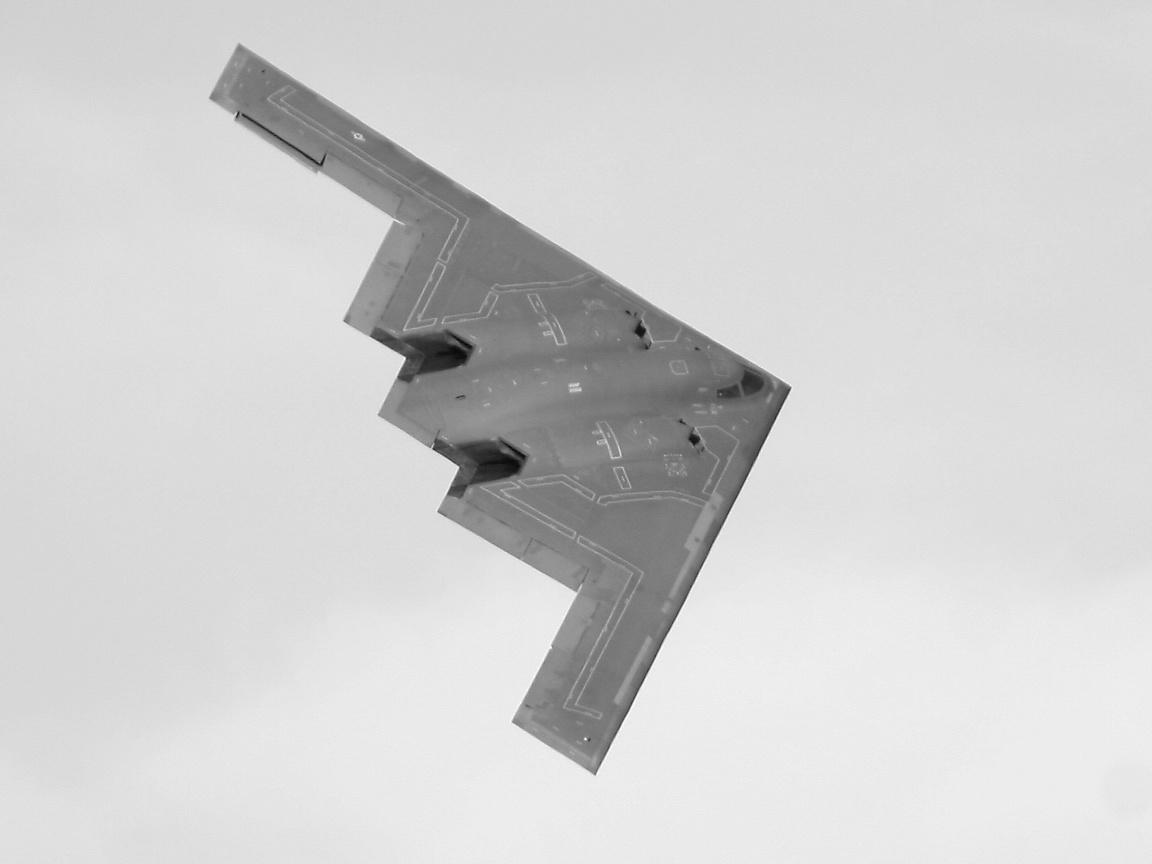

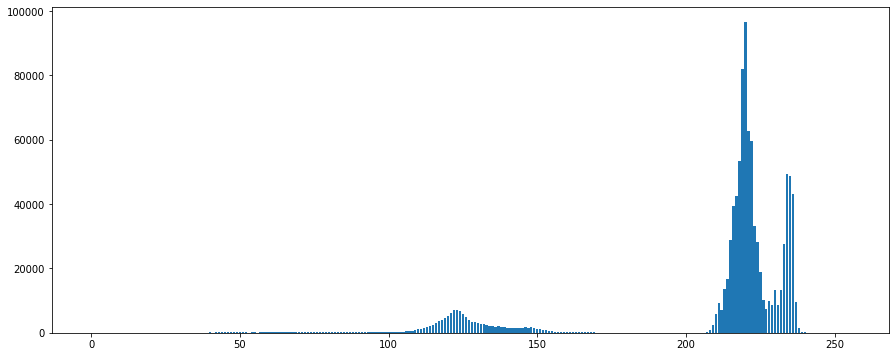

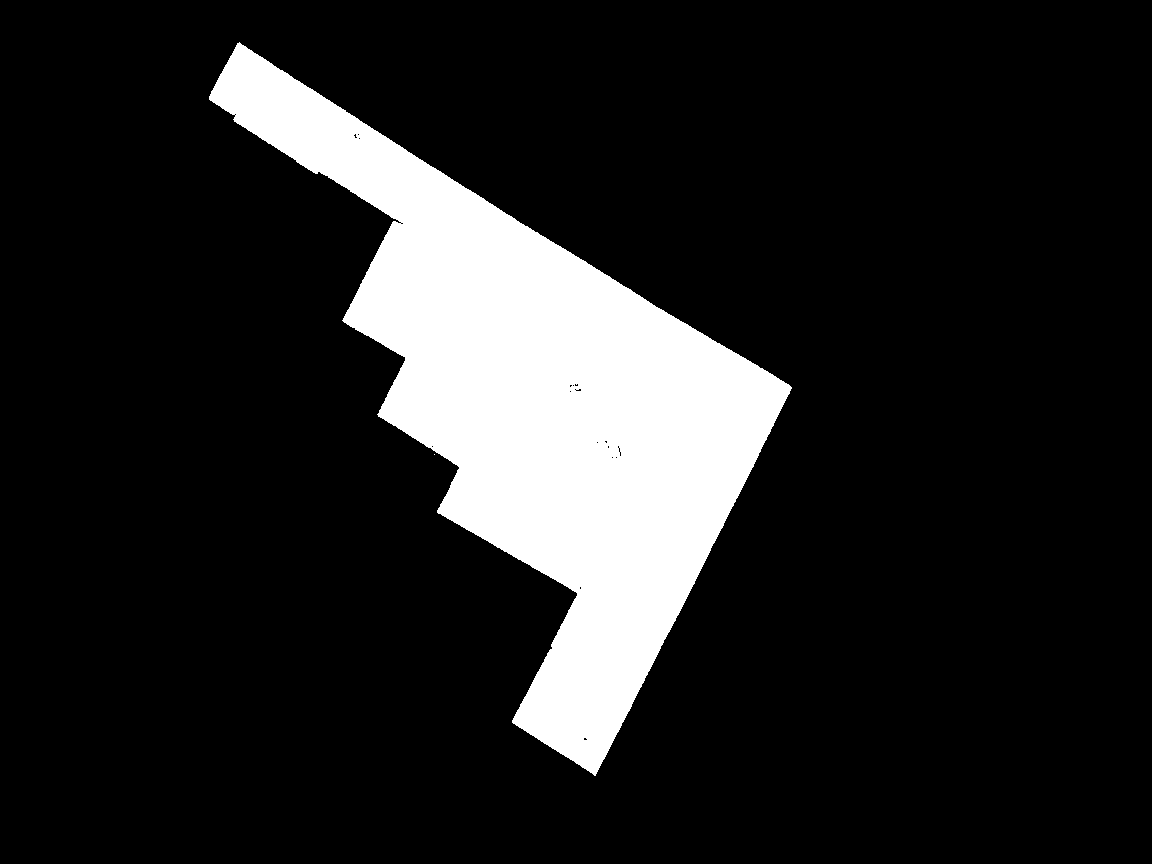

In [42]:
img1 = ImageOps.grayscale(Image.open("data/segmentacao/Image_(1).jpg"))
im_array1 = np.array(img1)
display(img1)
plot_histogram(im_array1)

im_array1_bin = binarizar(im_array1, 200)

im1_bin = Image.fromarray((im_array1_bin*255).astype(np.uint8))
display(im1_bin)

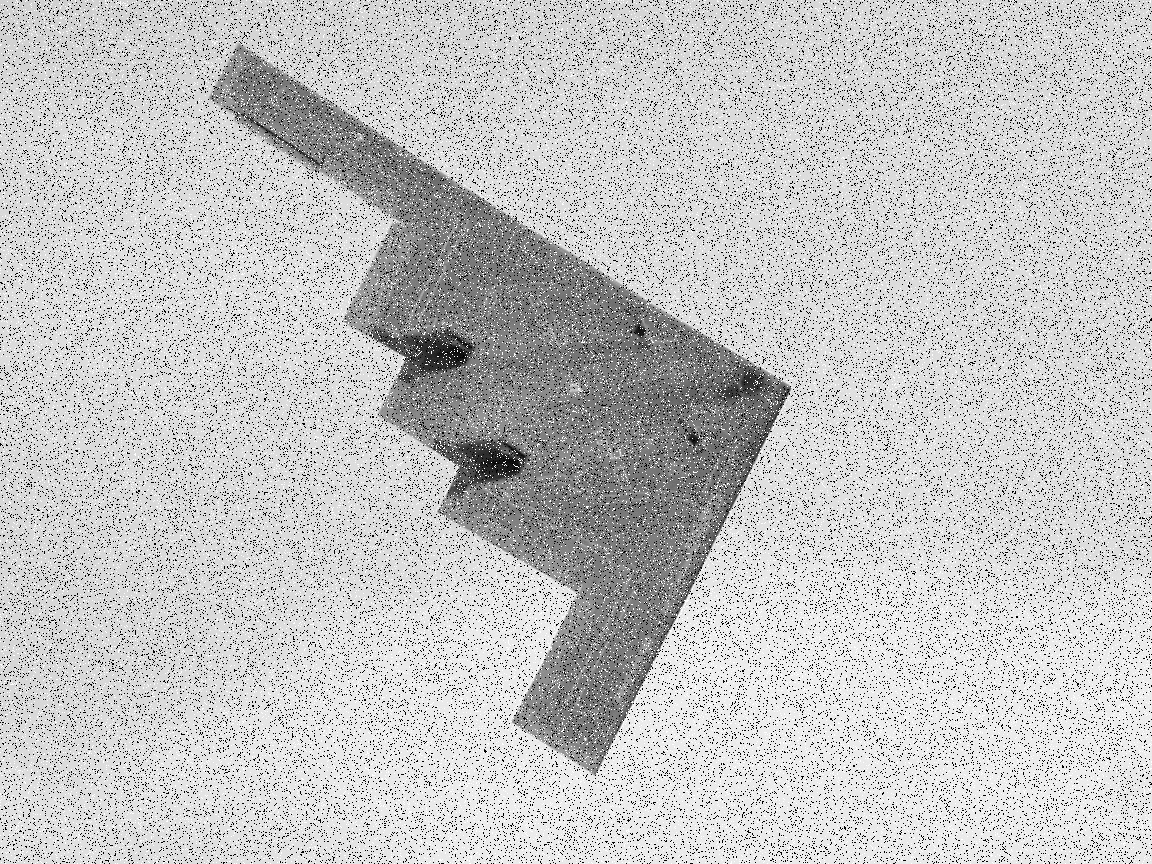

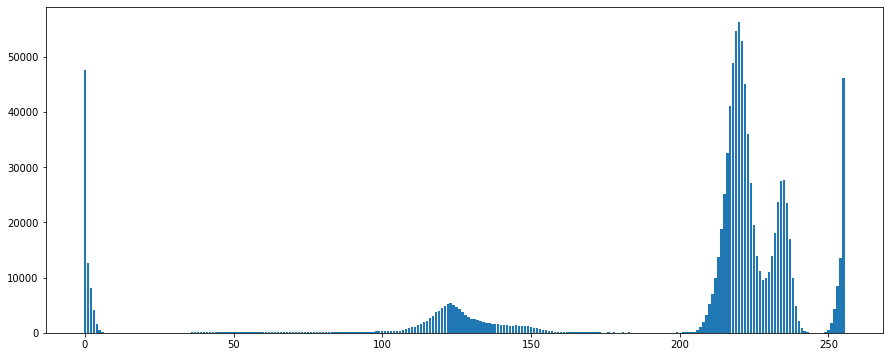

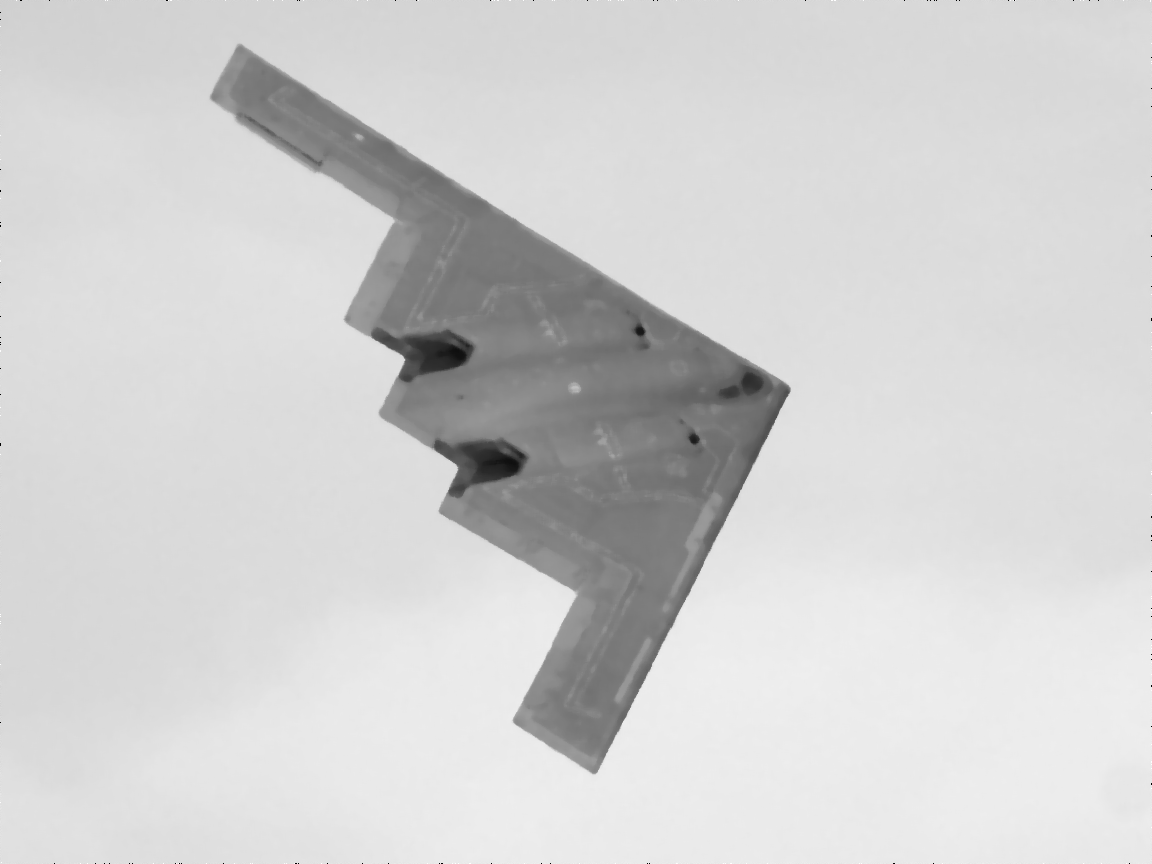

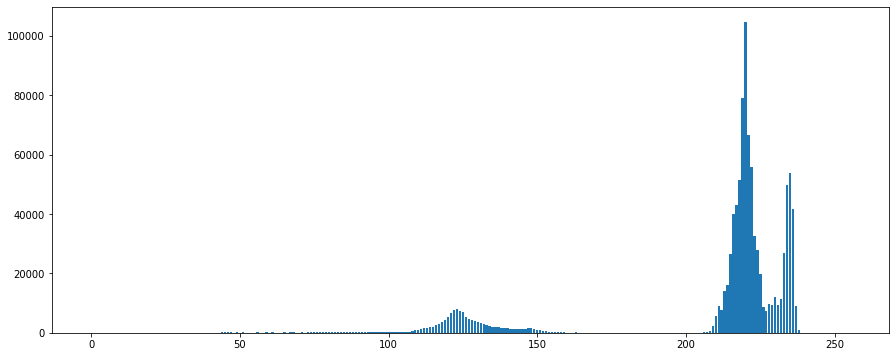

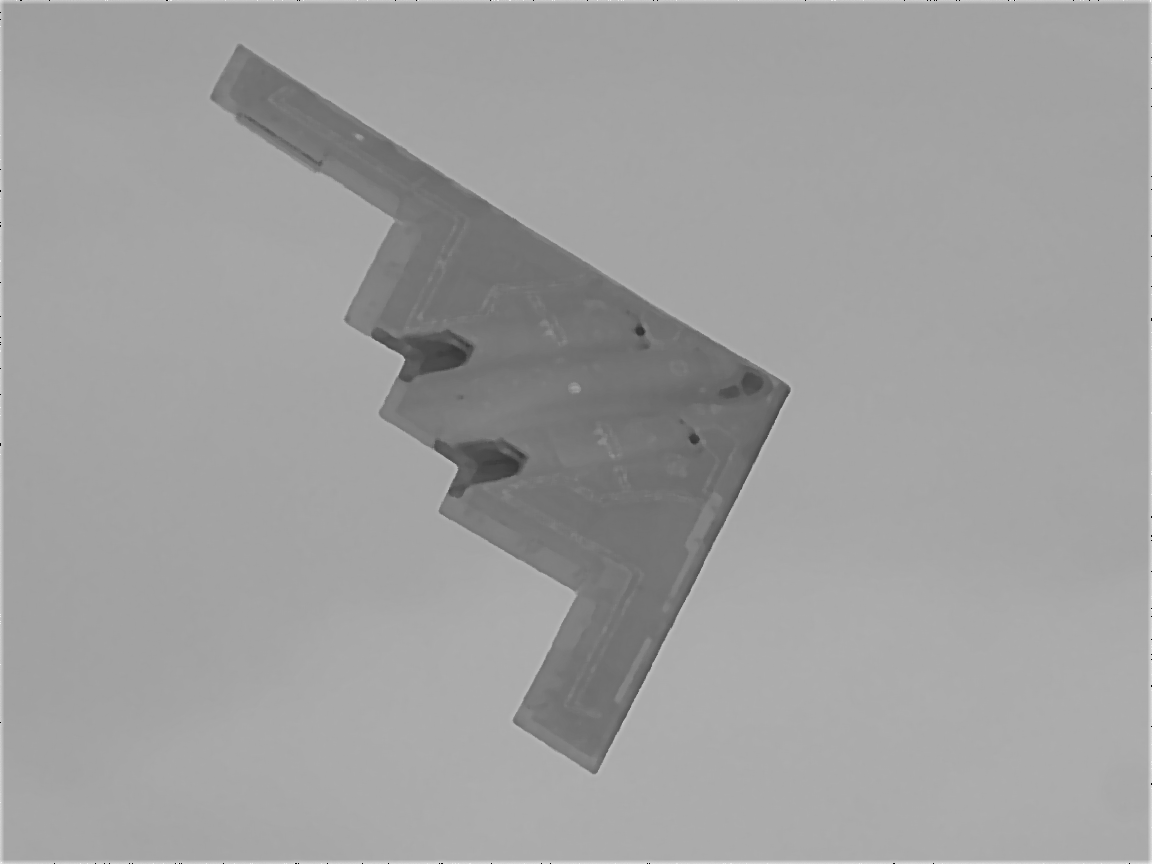

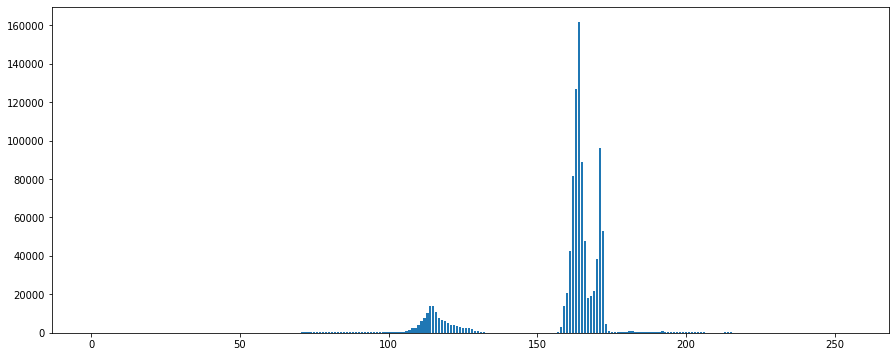

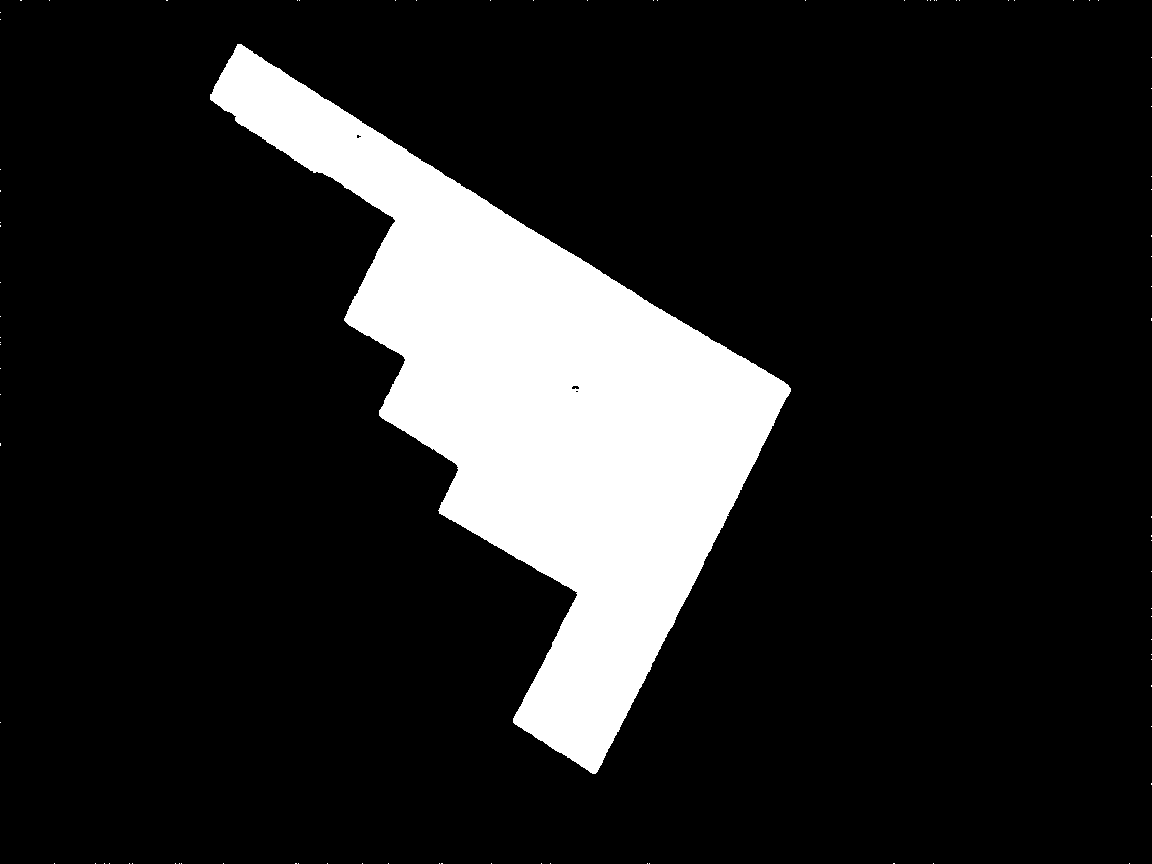

In [51]:
img1a = ImageOps.grayscale(Image.open("data/segmentacao/Image_(1a).jpg"))
im_array1a = np.array(img1a)
display(img1a)
plot_histogram(im_array1a)

im_array1a_clean = median(im_array1a, (7,7))
display(Image.fromarray(im_array1a_clean))
plot_histogram(im_array1a_clean)

im_array1a_ag = agucar_laplace(im_array1a_clean, (9,9))
display(Image.fromarray(im_array1a_ag))
plot_histogram(im_array1a_ag)

im_array1a_bin = binarizar(im_array1a_ag, 150)

im1a_bin = Image.fromarray((im_array1a_bin*255).astype(np.uint8))
# # im_suav.save("data/suavizar/result/Suavizar_box_(1).jpg")
display(im1a_bin)

## Imagem 2

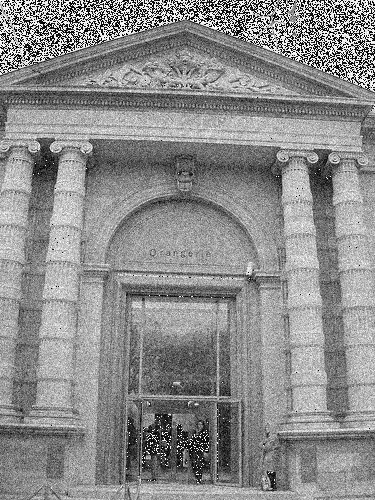

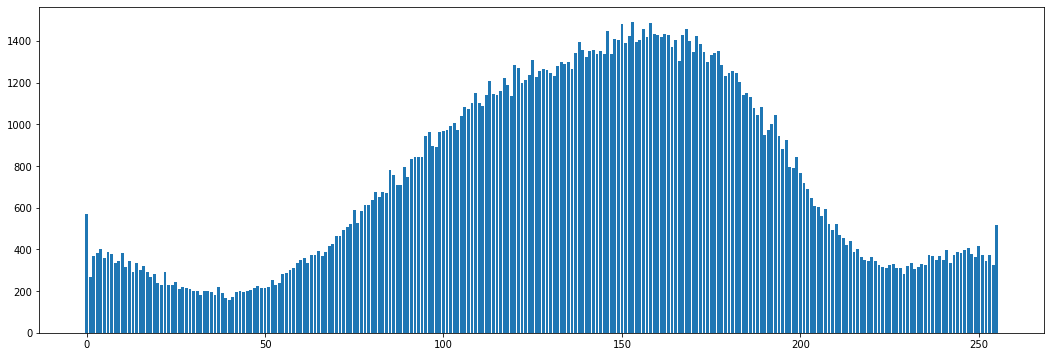

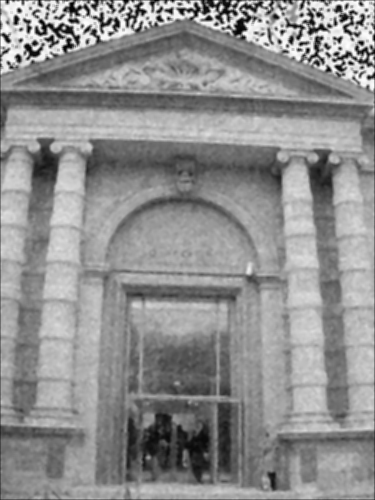

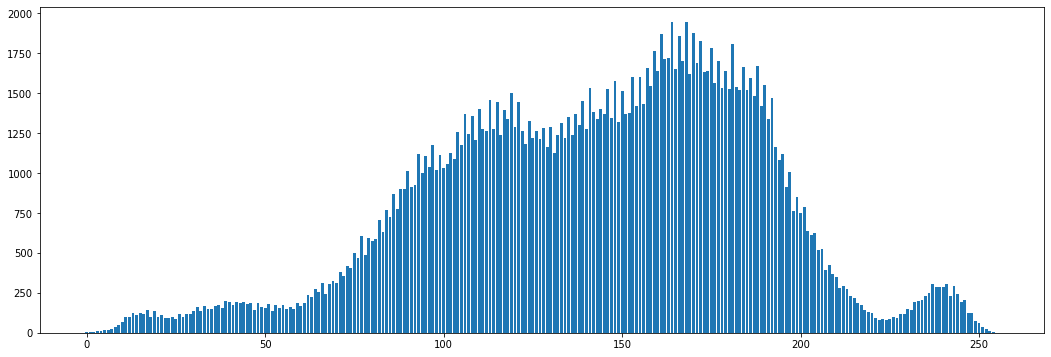

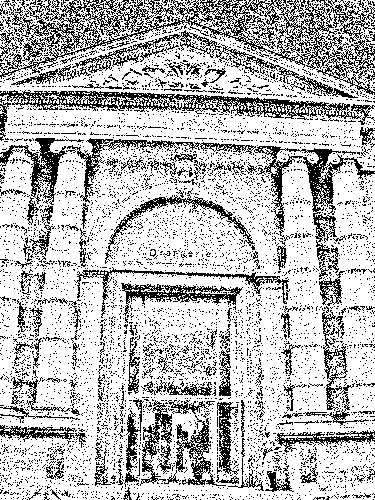

In [103]:
img2a = ImageOps.grayscale(Image.open("data/segmentacao/Image_(2a).jpg"))
im_array2a = np.array(img2a)
display(img2a)
plot_histogram(im_array2a)

im_array2a_clean = median(im_array2a, (3,3))
im_array2a_clean = median(im_array2a_clean, (3,3))
im_array2a_clean = arith_mean(im_array2a_clean, (3,3))
# im_array2a_clean = np.where(im_array2a > 2, im_array2a, 255)
display(Image.fromarray(im_array2a_clean))
plot_histogram(im_array2a_clean)

sauvola = filters.threshold_sauvola(im_array2a_clean, window_size=25)
# im_array2a_bin = binarizar(im_array2a_clean, 225, 30)
im_array2a_bin = im_array2a > sauvola

im2a_bin = Image.fromarray((im_array2a_bin*255).astype(np.uint8))
# im_suav.save("data/suavizar/result/Suavizar_box_(1).jpg")
display(im2a_bin)

## Imagem 3

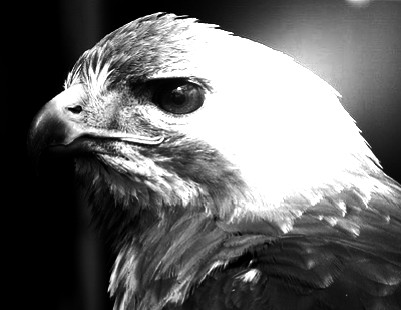

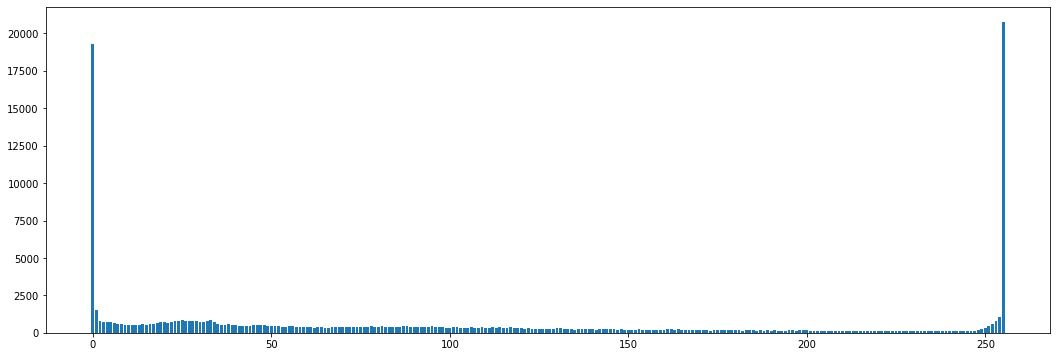

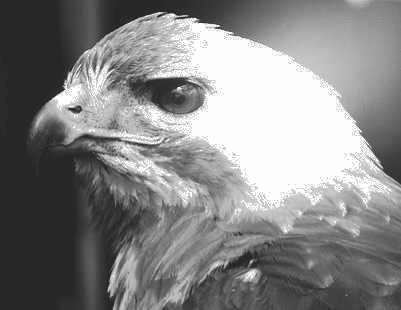

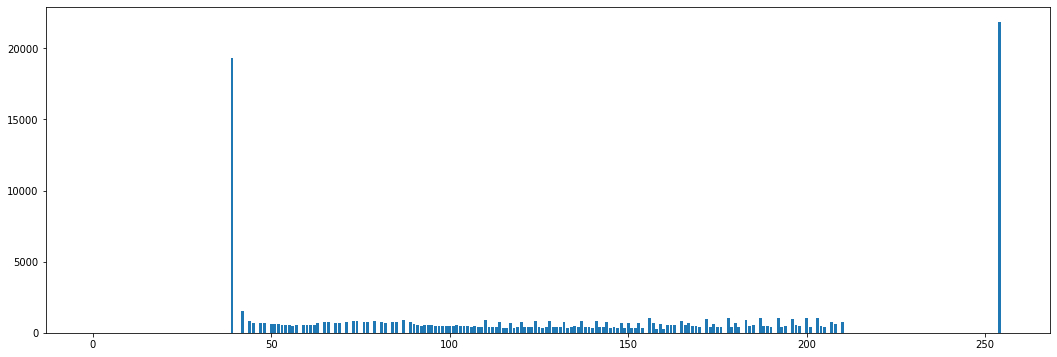

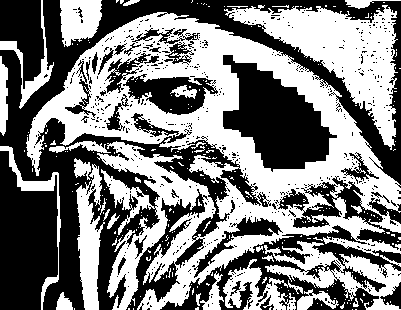

In [100]:
img3a = ImageOps.grayscale(Image.open("data/segmentacao/Image_(3a).jpg"))
im_array3a = np.array(img3a)
display(img3a)
plot_histogram(im_array3a)

im_array3a_eq = eq_histogram(im_array3a)
im_array3a_eq = gama(im_array3a_eq, c=1, g=0.1)
im_array3a_eq = pseudo_lp(im_array3a_eq, f=230)
im_array3a_eq = gama(im_array3a_eq, c=1, g=1.2)
im_array3a_eq = eq_histogram(im_array3a_eq)
display(Image.fromarray(im_array3a_eq))
plot_histogram(im_array3a_eq)

niblack = filters.threshold_niblack(im_array3a_eq, window_size=31)
im_array3a_bin = im_array3a_eq > niblack
im3a_bin = Image.fromarray(im_array3a_bin)
display(im3a_bin)

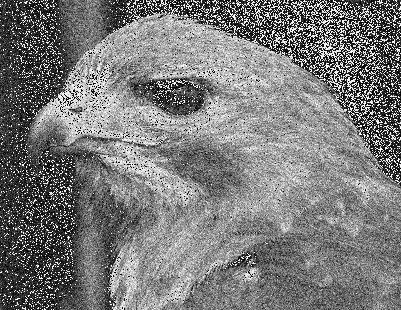

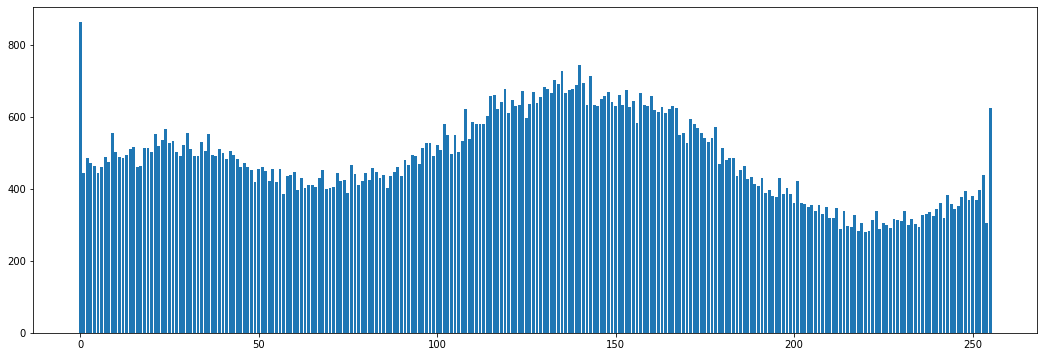

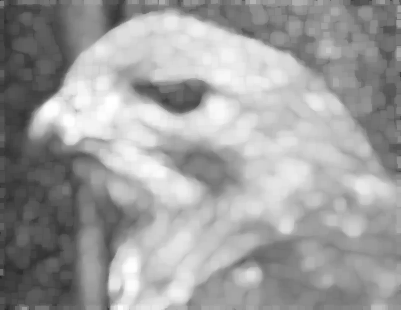

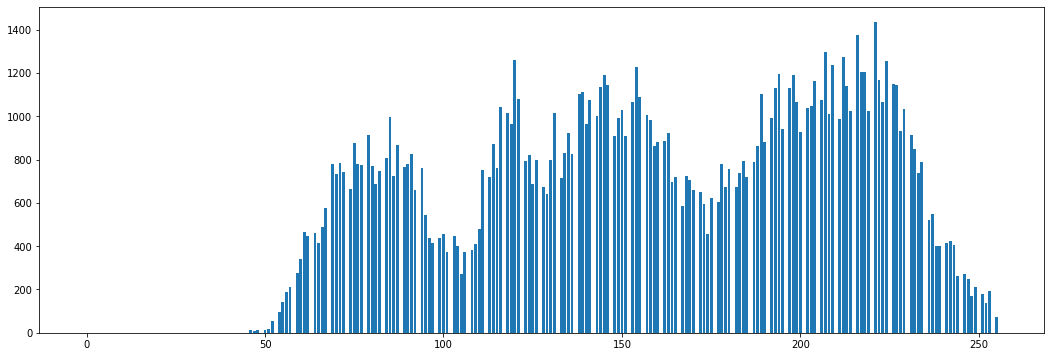

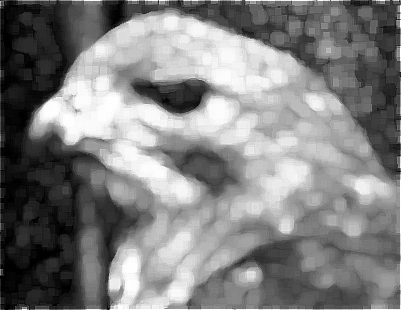

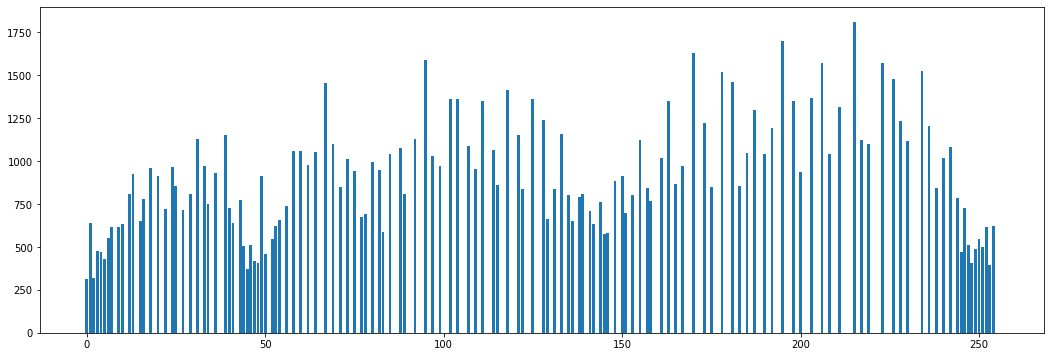

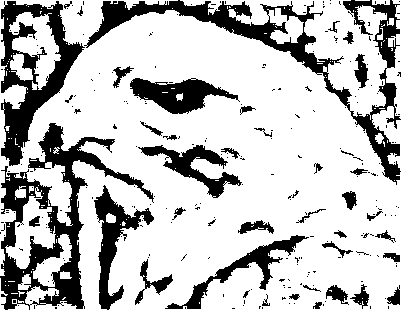

In [50]:
img3b = ImageOps.grayscale(Image.open("data/segmentacao/Image_(3b).jpg"))
im_array3b = np.array(img3b)
display(img3b)
plot_histogram(im_array3b)

im_array3b_clean = arith_mean(im_array3b, (3,3))
im_array3b_clean = median(im_array3b_clean, (11,11))
im_array3b_clean = max_filter(im_array3b_clean, (5,5))
display(Image.fromarray(im_array3b_clean))
plot_histogram(im_array3b_clean)

im_array3b_ag = agucar_laplace(im_array3b_clean, (5,5))
im_array3b_ag = agucar_laplace(im_array3b_clean, (3,3))
im_array3b_ag = eq_histogram(im_array3b_ag)
im_array3a_eq = gama(im_array3a_eq, c=1, g=0.6)
display(Image.fromarray(im_array3b_ag))
plot_histogram(im_array3b_ag)

sauvola = filters.threshold_sauvola(im_array3b_ag, window_size=31)
im_array3b_bin = im_array3b_ag > sauvola
display(Image.fromarray(im_array3b_bin))

## Imagem 4

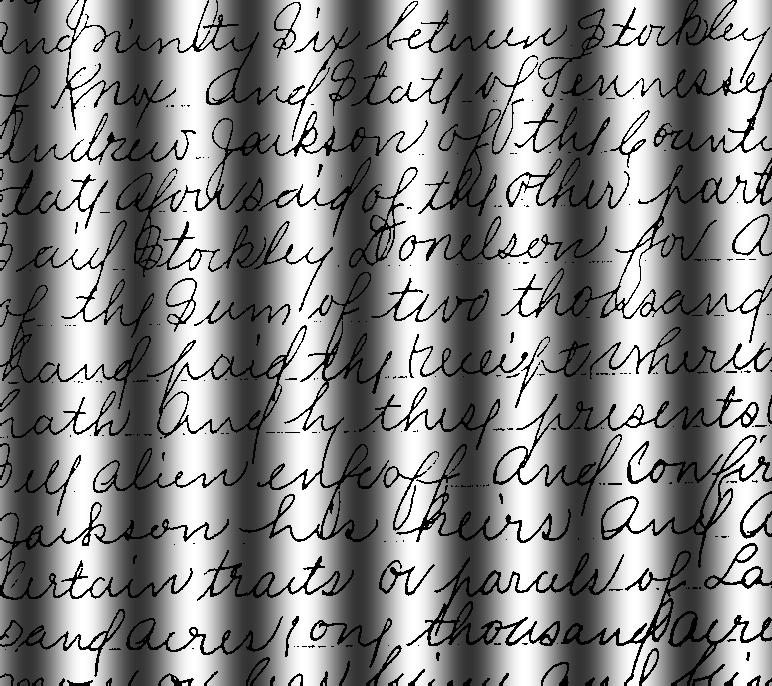

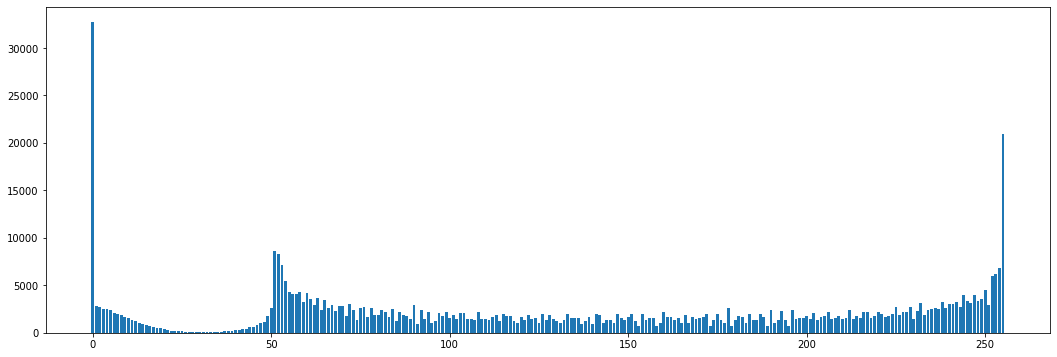

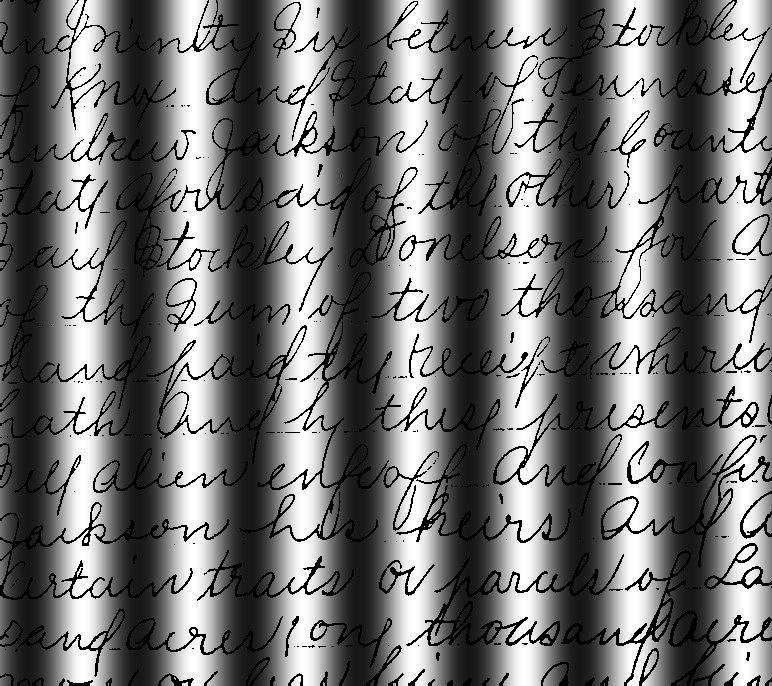

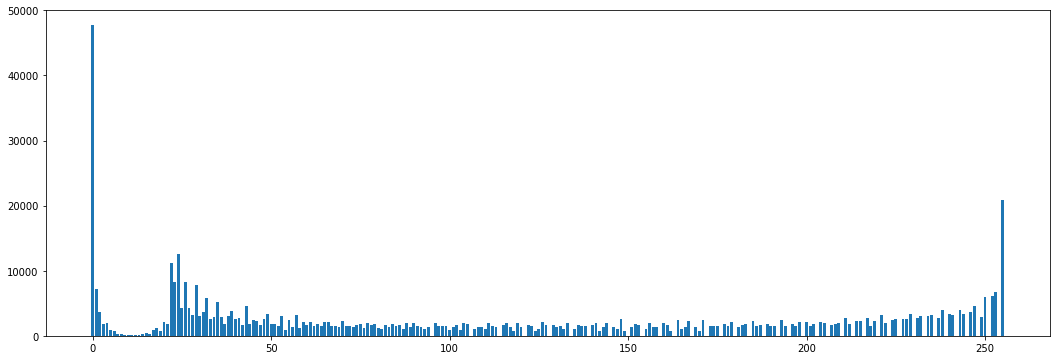

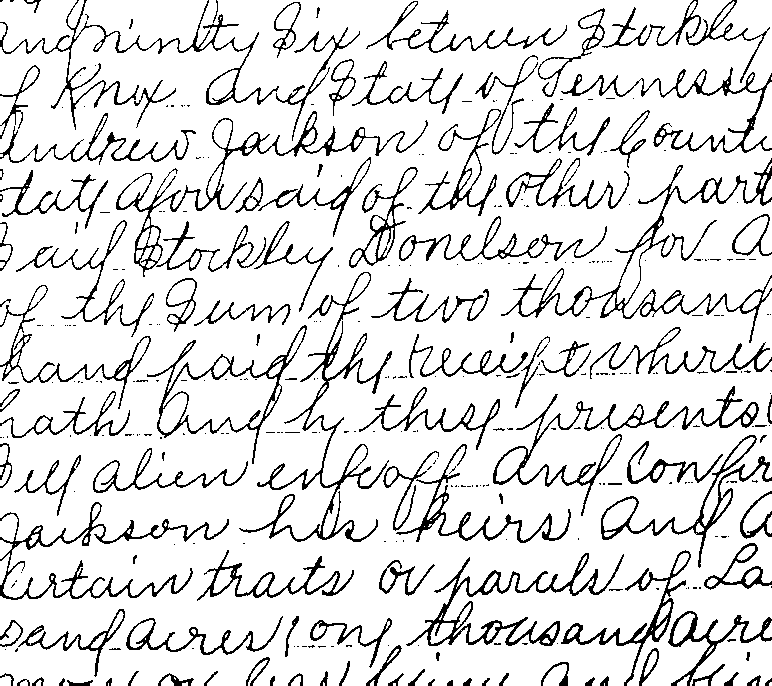

In [75]:
img4 = ImageOps.grayscale(Image.open("data/segmentacao/Image_(4).jpg"))
im_array4 = np.array(img4)
display(img4)
plot_histogram(im_array4)

# im_array4_clean = eq_histogram(im_array4)
im_array4_clean = gama(im_array4, g=1.5)
display(Image.fromarray(im_array4_clean))
plot_histogram(im_array4_clean)

sauvola = filters.threshold_sauvola(im_array4_clean, window_size=25)
im_array4_bin = im_array4 > sauvola
display(Image.fromarray(im_array4_bin))

## Imagem 5

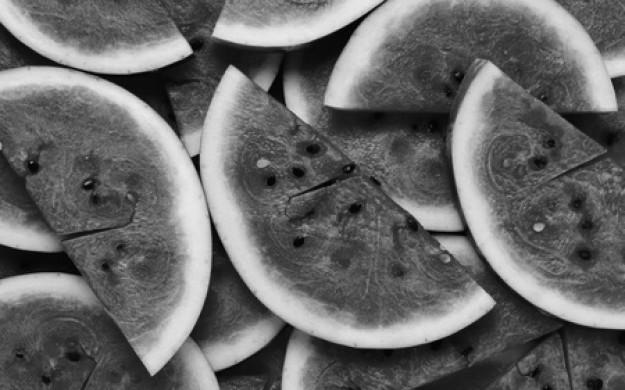

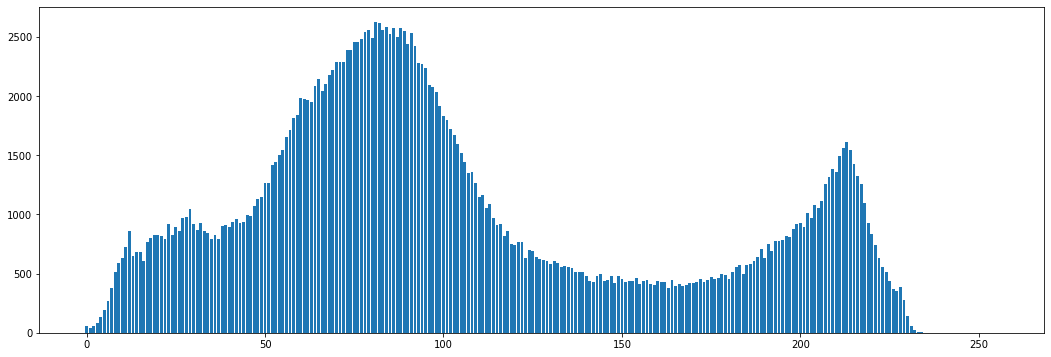

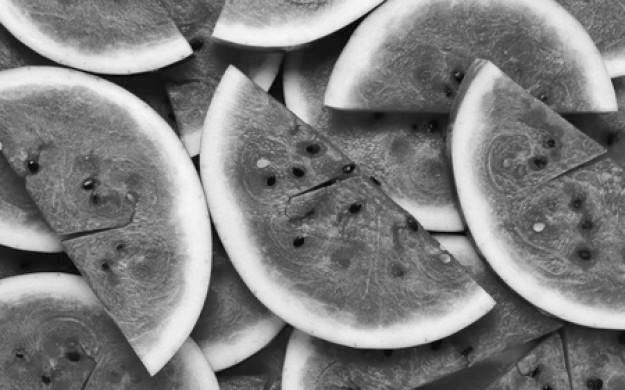

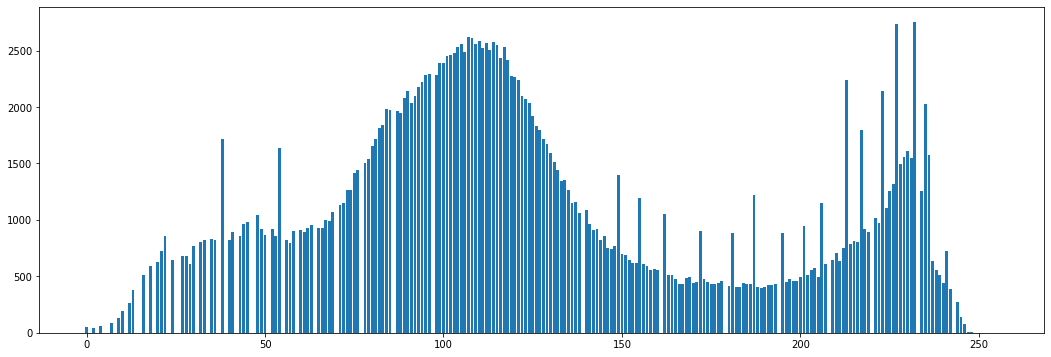

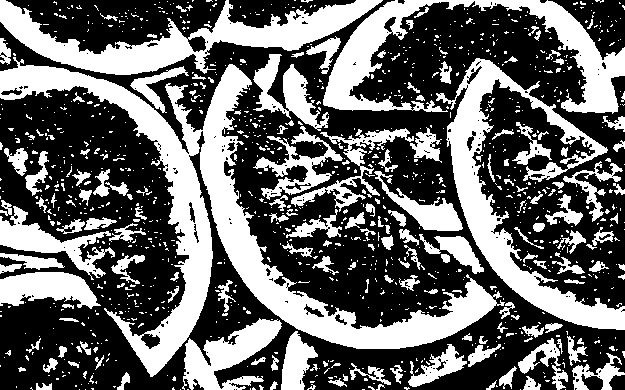

In [96]:
img5 = ImageOps.grayscale(Image.open("data/segmentacao/Image_(5).jpg"))
im_array5 = np.array(img5)
display(img5)
plot_histogram(im_array5)

im_array5_clean = gama(im_array5, g=0.75)
im_array5_clean = gama(im_array5_clean, g=1.1)
im_array5_clean = gama(im_array5_clean, g=0.95)
display(Image.fromarray(im_array5_clean))
plot_histogram(im_array5_clean)

niblack = filters.threshold_niblack(im_array5_clean, window_size=25, k=0.75)
im_array5_bin = im_array5 > niblack
display(Image.fromarray(im_array5_bin))